In [3]:
#pip install datasets
#pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Import all the required libraries

In [106]:
from datasets import load_dataset
from wordcloud import WordCloud, STOPWORDS
import string
import pandas as pd
import matplotlib.pyplot as plt

### Load text data from hugging face dataset and split only training data for EDA

In [79]:
dataset = load_dataset("wikitext",'wikitext-103-v1', split='train')

Reusing dataset wikitext (/Users/sahilbohot/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


In [80]:
dataset.info

DatasetInfo(description=' The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified\n Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike\n License.\n', citation='@misc{merity2016pointer,\n      title={Pointer Sentinel Mixture Models},\n      author={Stephen Merity and Caiming Xiong and James Bradbury and Richard Socher},\n      year={2016},\n      eprint={1609.07843},\n      archivePrefix={arXiv},\n      primaryClass={cs.CL}\n}\n', homepage='https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/', license='Creative Commons Attribution-ShareAlike 4.0 International (CC BY-SA 4.0)', features={'text': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='wikitext', config_name='wikitext-103-v1', version=1.0.0, splits={'test': SplitInfo(name='test', num_bytes=1295575, num_examples=4

#### I'll be using only train dataset for demonstration and convert it to pandas

In [114]:
df = pd.DataFrame(data = dataset)

In [115]:
df.describe()

,text
count,1801350
unique,971312
top,
freq,636321


### dataset has no null values

In [116]:
df.isnull().sum()

text    0
dtype: int64

### For simplicity and processing ease convert all text to lower case

In [117]:
df['text'] = df['text'].str.lower()
df.head()

,text
0,
1,= valkyria chronicles iii = \n
2,
3,senjō no valkyria 3 : <unk> chronicles ( japa...
4,"the game began development in 2010 , carrying..."


### In this part we will remove all the punctuations from the text for easier processing

In [118]:
def remove_punct(text):
    test = ''.join([c for c in text if c not in string.punctuation])
    return test

df['text'] = df['text'].apply(lambda x : remove_punct(x))

df.head()

,text
0,
1,valkyria chronicles iii \n
2,
3,senjō no valkyria 3 unk chronicles japanese...
4,the game began development in 2010 carrying ...


### Wordcloud is used to generate the cloud of words with most used words in bigger size

In [119]:
wc = WordCloud(
    background_color='white',
    stopwords = STOPWORDS,
    height = 800,
    width = 600,
    collocations=False
)

In [120]:
image = wc.generate(' '.join(df['text'].to_list()))

### Plotting the generated word cloud as image

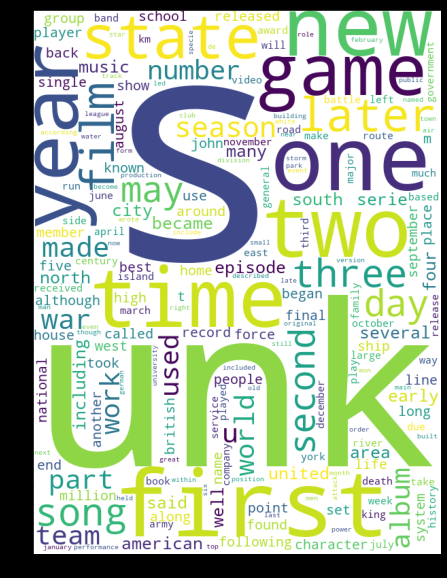

In [121]:
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(image)